In [14]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /workspaces/fil-rouge-pollinisateurs
Current working directory:  /workspaces/fil-rouge-pollinisateurs
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pandas as pd
target_df = pd.read_csv("spipoll_target_medium.csv")

## Small preprocessing 

In [20]:
# Dictionnaire de mapping des anciens noms de colonnes aux nouveaux noms de colonnes avec le bon encodage
nouveaux_noms_colonnes = {
    'impermeabilisÃ©_250': 'impermeabilisé_250',
    'impermeabilisÃ©_1000': 'impermeabilisé_1000',
    'semi_impermeabilisÃ©_250': 'semi_impermeabilisé_250',
    'semi_impermeabilisÃ©_1000': 'semi_impermeabilisé_1000'
}

# Renommer les colonnes en utilisant le dictionnaire de mapping
target_df = target_df.rename(columns=nouveaux_noms_colonnes)

In [16]:
# Get the year for each date in 'collection_heure_debut'
target_df['collection_heure_debut'] = pd.to_datetime(target_df['collection_heure_debut'])
year = target_df['collection_heure_debut'].dt.year

# Create a new column with the number of days from each date to the beginning of the year
target_df['jour_julien'] = (target_df['collection_heure_debut'] - pd.to_datetime(year, format='%Y')) / pd.Timedelta(days=1)

In [17]:
from models.preprocessors import split_in_dummies

target_df, dummies_col = split_in_dummies(target_df, "habitat", sep=",")

In [95]:
target_df.columns.values

array(['collection_id', 'collection_heure_debut', 'plante_famille',
       'plante_genre', 'plante_espece', 'habitat', 'nebulosite',
       'temperature', 'vent', 'insecte_ordre', 'insecte_famille',
       'insecte_fr', 'latitude', 'longitude', 'col21_250', 'col21_1000',
       'col22_250', 'col22_1000', 'col23_250', 'col23_1000', 'col24_250',
       'col24_1000', 'col31_250', 'col31_1000', 'col32_250', 'col32_1000',
       'col33_250', 'col33_1000', 'col4et5_250', 'col4et5_1000',
       'impermeabilisé_250', 'impermeabilisé_1000',
       'semi_impermeabilisé_250', 'semi_impermeabilisé_1000',
       'position.3', 'temp_mois_prev', 'temp_avril_prev',
       'temp_avril_current', 'temp_hiver', 'prep_mois_prev',
       'prep_avril_prev', 'prep_avril_current', 'prep_hiver',
       'prep_moyenne', 'temp_moyenne', 'specific_richness', 'density',
       'collection_id_density', 'weighted_specific_richness',
       'jour_julien', "bord de l'eau", 'bord de route', 'forêt',
       'grande(s) cul

In [112]:
cols_corine_num = [
        'col21_250', 'col21_1000',
       'col22_250', 'col22_1000', 'col23_250', 'col23_1000', 'col24_250',
       'col24_1000', 'col31_250', 'col31_1000', 'col32_250', 'col32_1000',
       'col33_250', 'col33_1000', 'col4et5_250', 'col4et5_1000',
       'impermeabilisé_250', 'impermeabilisé_1000',
       'semi_impermeabilisé_250', 'semi_impermeabilisé_1000',
        'temp_mois_prev', 'temp_avril_prev',
       'temp_avril_current', 'temp_hiver', 'prep_mois_prev',
       'prep_avril_prev', 'prep_avril_current', 'prep_hiver',
       'prep_moyenne', 'temp_moyenne'
       ]
cols_corine_cat = ["position.3"]
numeric_features = [
    # "latitude",
    # "longitude",
    # "collection_heure_debut_cos",
    "jour_julien"
] + cols_corine_num

ordinal_features = ["vent", "nebulosite", "temperature"] 

# if dummies_col is defined
nominal_features = [
    "plante_famille",
    "insecte_ordre"
    # ..., 
] + dummies_col + cols_corine_cat

categorical_features = ordinal_features + nominal_features

used_features = numeric_features + ordinal_features + nominal_features

In [113]:
target_name = "specific_richness"
#target_name = "weighted_specific_richness"
X = target_df[used_features]
y = target_df[target_name]

In [136]:
from models.supervised.pipeline import CustomPipeline

pipe = CustomPipeline(
    numeric_features, categorical_features, ordinal_features, nominal_features, feature_selection=True
)

In [137]:
from models.preprocessors import TrainTestUnderSampler

kwargs = {
    "min_thresholds": [0.0],
    "max_thresholds": [0.00],
    "sample_percentages": [0.001],
    "column_name": target_name
}

sampler = TrainTestUnderSampler(**kwargs)

X_train, X_test, y_train, y_test = sampler.preprocess(X, y)

In [138]:
pipe.fit(X_train, y_train)

In [139]:
pipe.get_metrics(X_test, y_test)

R2: 0.9815864446636073
MSE: 4.825170595928676
MAE: 0.4870179621585784


(0.9815864446636073, 4.825170595928676, 0.4870179621585784)

## Sauvegarde du modèle

In [140]:
from joblib import dump, load
dump(pipe, "model_specific_selection.joblib")

['model_specific_selection.joblib']

In [ ]:
load("models/supervised/model_coord_weighted.joblib")

## Application carte

In [147]:
pipe = load("models/supervised/model_specific.joblib")

In [141]:
france_data = pd.read_csv("data/temporary_data/france_place_modele.csv", sep=";")

In [142]:
france_data.rename(
    columns={
        "lat": "latitude",
        "long": "longitude",
    },
    inplace=True,
)

In [143]:
# create columns if not existent from used_features
import numpy as np
for col in used_features:
    if col not in france_data.columns:
        france_data[col] = np.nan

In [144]:
france_data_temp = france_data[used_features]
#france_data.drop(["longitude", "latitude"])
france_data["results"] = pipe.predict(france_data_temp[used_features])

In [155]:
try:
    importance = pipe.pipeline.named_steps["estimator"].feature_importances_
    feature_names = pipe.pipeline.steps[0][1].get_feature_names_out()

    feature_importance = pd.DataFrame(
        {"feature": feature_names, "importance (%)": importance * 100}
    ).sort_values("importance (%)", ascending=False)
except AttributeError:
    feature_importance = pd.DataFrame()
feature_importance.head(50)

,feature,importance (%)
30,numerical__temp_moyenne,39.293378
29,numerical__prep_moyenne,34.404794
16,numerical__col4et5_1000,3.462482
10,numerical__col31_1000,2.573467
2,numerical__col21_1000,1.910949
20,numerical__semi_impermeabilisé_1000,1.671239
12,numerical__col32_1000,1.669917
6,numerical__col23_1000,1.488702
24,numerical__temp_hiver,1.330283
18,numerical__impermeabilisé_1000,1.088325


/tmp/ipykernel_31872/1940186154.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


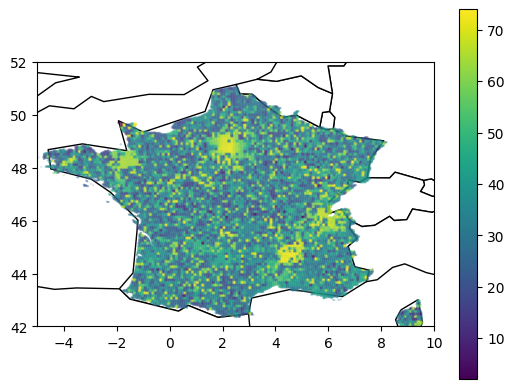

In [145]:
# plot the predictions in france map with the data knowing that france_data has lat and long
# use a map contour  
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming your DataFrame is named df and has columns "latitude", "longitude", and "results"
gdf = gpd.GeoDataFrame(france_data, geometry=gpd.points_from_xy(france_data.longitude, france_data.latitude))

# Load the map of France
france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france_boundary = france.unary_union

# Plot the map of France
ax = france.plot(color='white', edgecolor='black')

# Plot the results on the map
gdf.plot(ax=ax, column='results', legend=True, markersize=0.01)

# Set the bounding box to focus on France
ax.set_xlim(-5, 10)  # Longitude limits for France
ax.set_ylim(42, 52)  # Latitude limits for France


# Show the plot
plt.show()

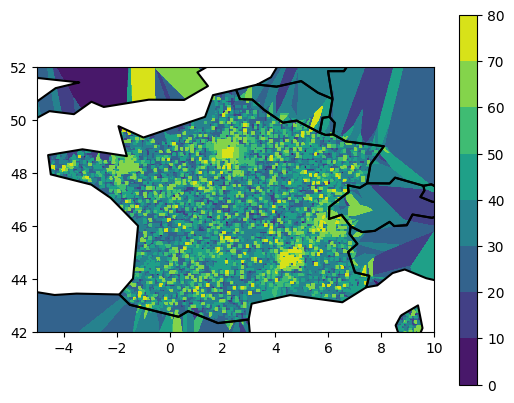

In [146]:
from shapely.geometry import box, Point
from scipy.interpolate import griddata

# Define the grid for interpolation
x = gdf['longitude']
y = gdf['latitude']
z = france_data['results']

# Create a grid of points within the bounding box of France
x_grid, y_grid = np.mgrid[-5:10:1000j, 42:52:1000j]

# Interpolate the data values on the grid
z_grid = griddata((x, y), z, (x_grid, y_grid), method='nearest')

# Get the boundary of metropolitan France
france_boundary = france.unary_union

# Create a bounding box for metropolitan France
bbox = box(minx=-5, miny=42, maxx=10, maxy=52)

# Create the mask for metropolitan France
mask = bbox.intersection(france_boundary)

# Create individual points for the mask
points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
mask_values = np.array([mask.contains(Point(p)) for p in points])
mask_values = mask_values.reshape(x_grid.shape)

# Apply the mask to the interpolated data and plot
masked_data = np.where(mask_values, z_grid, np.nan)
plt.contourf(x_grid, y_grid, masked_data, cmap='viridis')
plt.colorbar()
france.boundary.plot(ax=plt.gca(), color='black')
# Set the bounding box to focus on France
plt.xlim(-5, 10)  # Longitude limits for France
plt.ylim(42, 52)  # Latitude limits for France


# Show the plot
plt.show()